In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import cmocean.cm as cmo
from xgcm import Grid
import matplotlib.gridspec as gridspec

In [2]:
from distributed import Client, progress, LocalCluster
import socket

client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})
client


/home/z3533092/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 23785 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:23785/status,
Dashboard: http://127.0.0.1:23785/status,Workers: 2
Total threads: 2,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:30925,Workers: 2
Dashboard: http://127.0.0.1:23785/status,Total threads: 2
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:25459,Total threads: 1
Dashboard: http://127.0.0.1:20735/status,Memory: 56.00 GiB
Nanny: tcp://127.0.0.1:34687,


In [3]:



def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False, 
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    })
    return gridOut

In [4]:
def load_roms(filename,overlap):
    chunks = {'ocean_time': 1}
    glb_files = sorted(glob(filename))
    
    def preprocessRemoveOverlap(ds):
        '''remove the overlap from each file'''
        return ds.isel(ocean_time = slice(0,-overlap))

    for files in glb_files: 
        print(files)
        
    ds = xr.open_mfdataset(glb_files, chunks=chunks, preprocess=preprocessRemoveOverlap, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
    print('Loading data: OK!')
    return ds


# grid.transform(ds.temp.mean(dim='ocean_time'), 'Z', np.array([-500]),target_data=ds.z_rho0,method='linear').squeeze()

In [5]:
enoi = load_roms(filename='/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc',overlap=19)
_4dvar = load_roms(filename='/srv/scratch/z3533092/assimilation_newV2017_traditionalobs/ocean_fwd_001_04367.nc',overlap=7)

/srv/scratch/z3097808/forecasts_EnOI_TRADobs/output/eac_his_04811.nc
Loading data: OK!
/srv/scratch/z3533092/assimilation_newV2017_traditionalobs/ocean_fwd_001_04367.nc
Loading data: OK!


#### data prep

In [6]:
enoi = processROMSGrid(enoi)
grid = makeROMSGridObject(enoi)

_4dvar = processROMSGrid(_4dvar)
grid_4dvar = makeROMSGridObject(_4dvar)

In [7]:
#### Load conversion data

enoi_eke = xr.open_dataarray('enoi_eke_timemean.nc')
enoi_mke = xr.open_dataarray('enoi_mke_full.nc')

_4dvar_eke = xr.open_dataarray('4dvar_eke_timemean.nc')
_4dvar_mke = xr.open_dataarray('4dvar_mke_full.nc')

#### make means


In [8]:
# eke_0_400=grid.average(eke.where(enoi.z_rho>-400),'Z')
# eke_0_400=grid.average(eke.where(enoi.z_rho>-400),'Z')
enoi_eke_0_400=enoi_eke.where(enoi.z_rho0>-400).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')
enoi_mke_0_400=enoi_mke.where(enoi.z_rho0>-400).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')

# eke_400_1200=grid.average(eke.where((enoi.z_rho<-400)&(enoi.z_rho>-1200)),'Z')
# mke_400_1200=grid.average(mke.where((enoi.z_rho0<-400)&(enoi.z_rho0>-1200)),'Z')
enoi_eke_400_1200=enoi_eke.where((enoi.z_rho0<-400)&(enoi.z_rho0>-1200)).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')
enoi_mke_400_1200=enoi_mke.where((enoi.z_rho0<-400)&(enoi.z_rho0>-1200)).weighted(weights=enoi.dz.mean(dim='ocean_time')).mean(dim='s_rho')

_4dvar_eke_0_400=_4dvar_eke.where(_4dvar.z_rho0>-400).weighted(weights=_4dvar.dz.mean(dim='ocean_time')).mean(dim='s_rho')
_4dvar_mke_0_400=_4dvar_mke.where(_4dvar.z_rho0>-400).weighted(weights=_4dvar.dz.mean(dim='ocean_time')).mean(dim='s_rho')
_4dvar_eke_400_1200=_4dvar_eke.where((_4dvar.z_rho0<-400)&(_4dvar.z_rho0>-1200)).weighted(weights=_4dvar.dz.mean(dim='ocean_time')).mean(dim='s_rho')
_4dvar_mke_400_1200=_4dvar_mke.where((_4dvar.z_rho0<-400)&(_4dvar.z_rho0>-1200)).weighted(weights=_4dvar.dz.mean(dim='ocean_time')).mean(dim='s_rho')

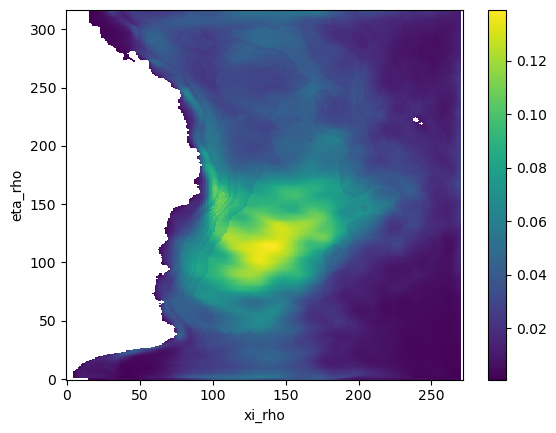

In [9]:
enoi_eke_0_400.plot()

#### Start plotting

In [10]:
Coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
CoastHR = cfeature.GSHHSFeature(scale='auto')

<Figure size 640x480 with 0 Axes>

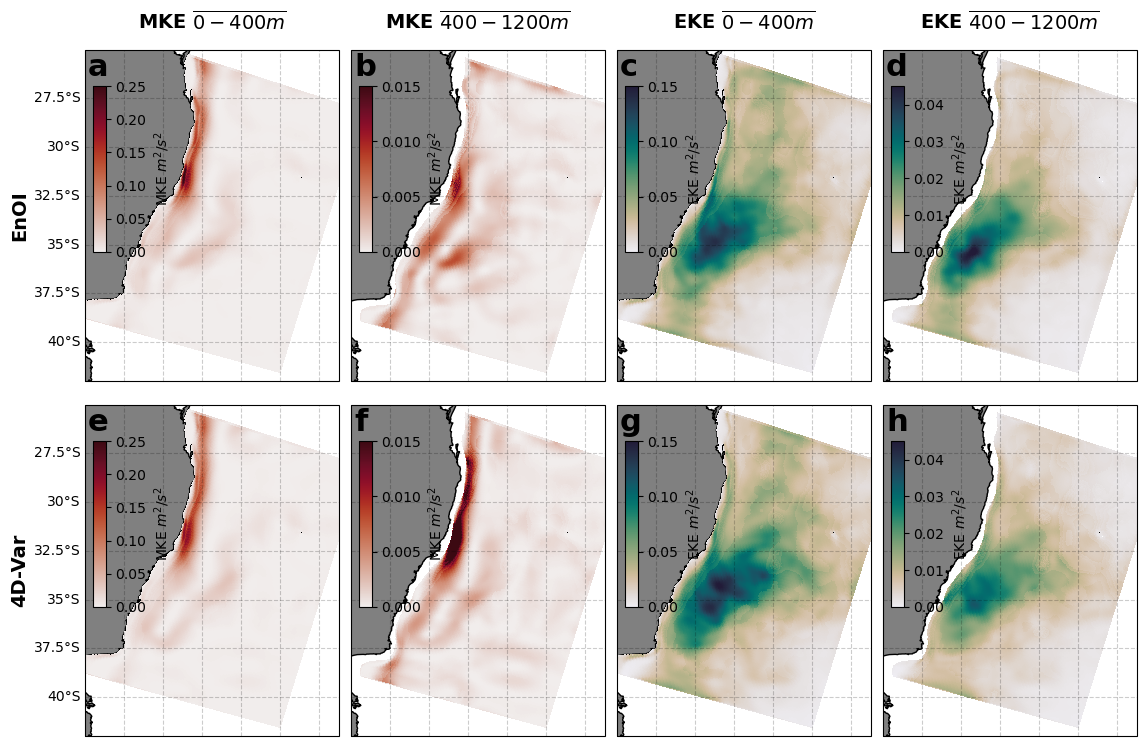

In [11]:



def addSubplot_spatialMap(input,Grid,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(Grid.lon_rho,Grid.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im

def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[17,9])
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_0_400,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.25'})
gl.left_labels = True
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.5, 1.12, 'MKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'MKE $m^2$/$s^2$')

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.015'})
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'MKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'MKE $m^2$/$s^2$')

ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_0_400,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.15'})
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'EKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'EKE $m^2$/$s^2$')

ax = fig.add_subplot(gs[0,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.045'})
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'EKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'EKE $m^2$/$s^2$')



ax = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_mke_0_400,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.25'})
gl.left_labels = True
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.5, 1.12, 'MKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'MKE $m^2$/$s^2$')

ax = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_mke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.015'})
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'MKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'MKE $m^2$/$s^2$')

ax = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_eke_0_400,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.15'})
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'EKE $m^2$/$s^2$')

ax = fig.add_subplot(gs[1,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_eke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.045'})
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
addInsetColormap(ax,im,'EKE $m^2$/$s^2$')



<Figure size 640x480 with 0 Axes>

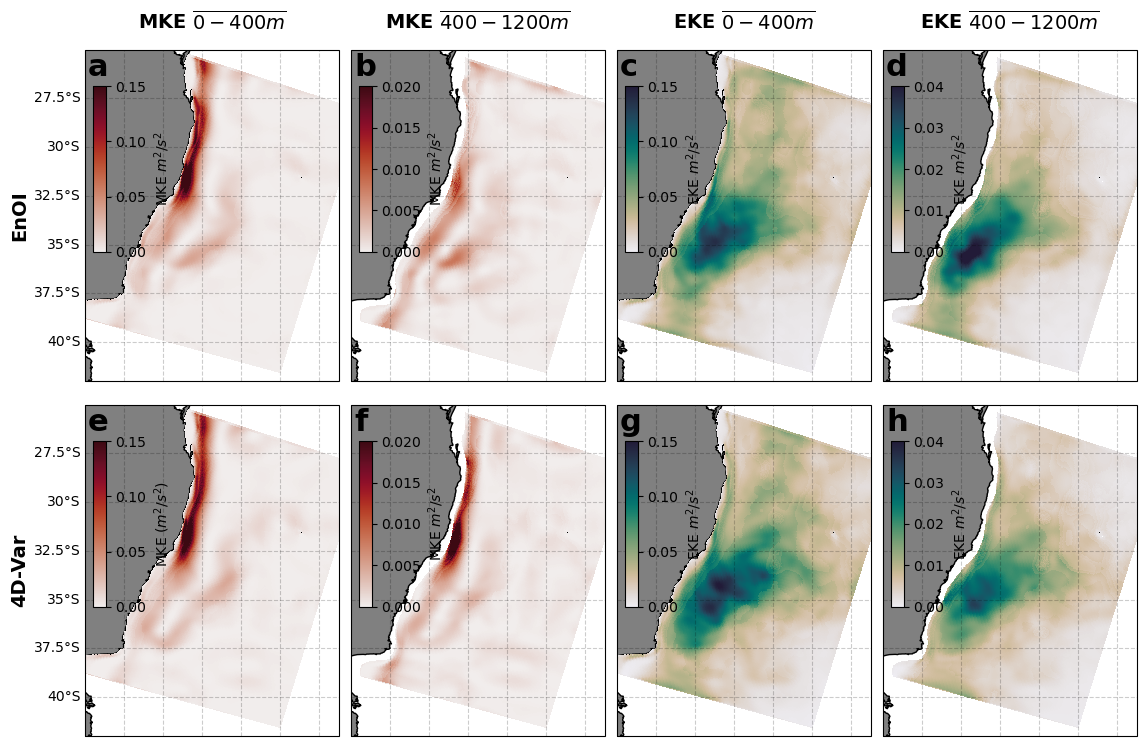

In [12]:



def addSubplot_spatialMap(input,Grid,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(Grid.lon_rho,Grid.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im

def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)
    return cbar


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[17,9])
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_0_400,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_mke_0_400,colors='k',linewidths=0.5,levels=np.arange(0,0.2,0.05))
gl.left_labels = True
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.5, 1.12, 'MKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.02'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.03,0.01))
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'MKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_0_400,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_eke_0_400,colors='k',linewidths=0.5,levels=np.arange(0,0.15,0.05))
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'EKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[0,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_eke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.05,0.01))
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'EKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)



ax = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_mke_0_400,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_0_400,colors='k',linewidths=0.5,levels=np.arange(0,0.2,0.05))
gl.left_labels = True
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.5, 1.12, 'MKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE ($m^2$/$s^2$)')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_mke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.02'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.03,0.01))
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'MKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_eke_0_400,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.15,0.05))
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[1,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_eke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.06,0.01))
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)



<Figure size 640x480 with 0 Axes>

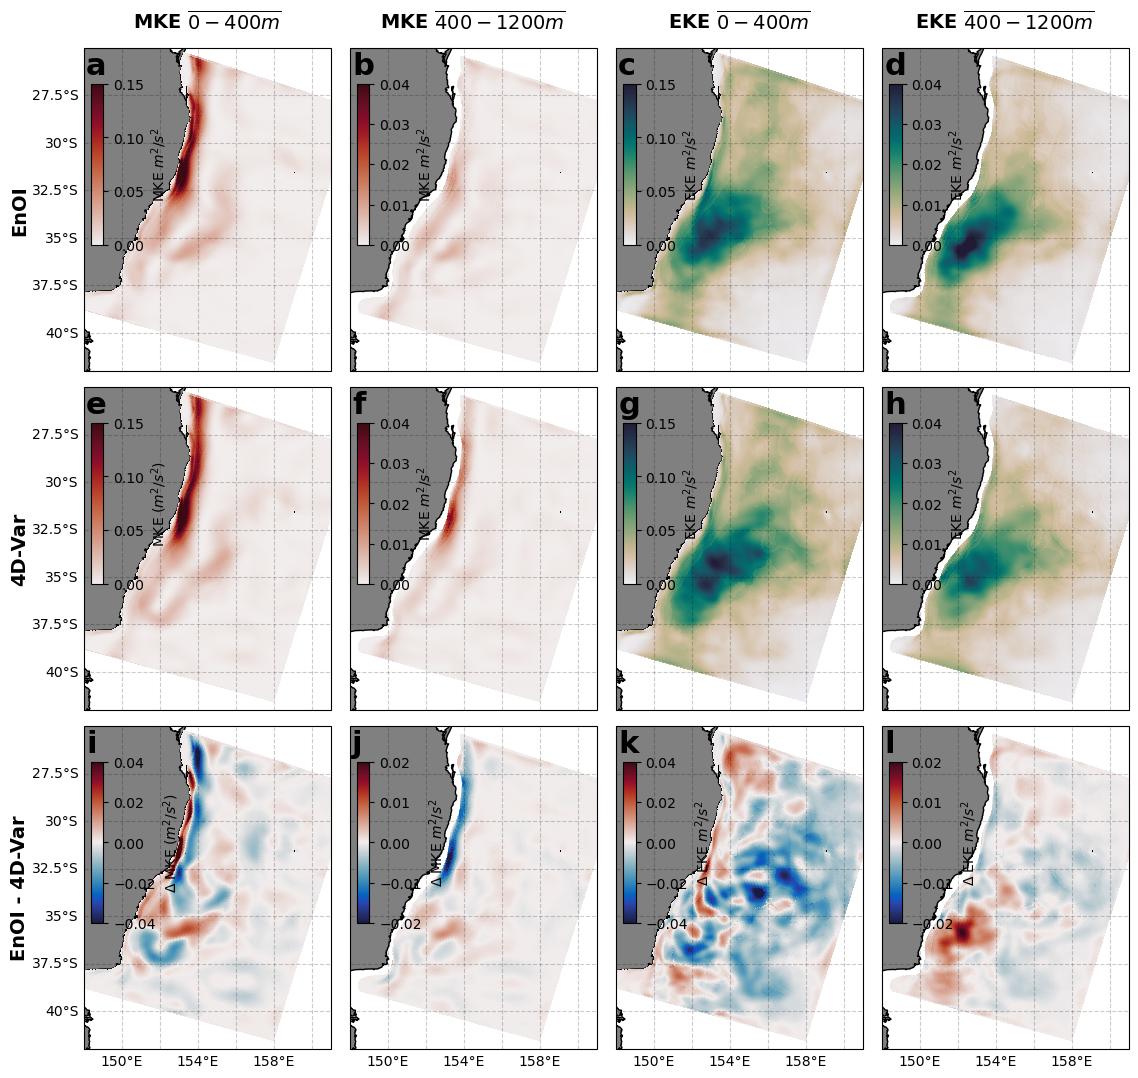

In [21]:
# calculate difference and add as third row




def addSubplot_spatialMap(input,Grid,pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(Grid.lon_rho,Grid.lat_rho,input,**pcol_kwargs)   
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    ax.set_title('')
    return gl,im

def addInsetColormap(ax,im,lab):
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label(lab)
    return cbar


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=3,ncols=5,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[17,13])
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_0_400,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_mke_0_400,colors='k',linewidths=0.5,levels=np.arange(0,0.2,0.05))
gl.left_labels = True
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, 'EnOI',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
ax.text(0.5, 1.12, 'MKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.03,0.01))
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'MKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_0_400,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_eke_0_400,colors='k',linewidths=0.5,levels=np.arange(0,0.15,0.05))
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'EKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[0,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,enoi_eke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.05,0.01))
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(0.5, 1.12, 'EKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)



ax = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_mke_0_400,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_0_400,colors='k',linewidths=0.5,levels=np.arange(0,0.2,0.05))
gl.left_labels = True
ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, '4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.5, 1.12, 'MKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE ($m^2$/$s^2$)')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_mke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.amp','vmin':'0','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.03,0.01))
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'MKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'MKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[1,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_eke_0_400,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.15'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.15,0.05))
ax.text(0.01, 0.99, 'g', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[1,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(_4dvar_eke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.rain','vmin':'0','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.06,0.01))
ax.text(0.01, 0.99, 'h', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'EKE $m^2$/$s^2$')
# cbar.add_lines(co)





ax = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_0_400-_4dvar_mke_0_400,enoi,pcol_kwargs={'cmap':'cmo.balance','vmin':'-.04','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_0_400,colors='k',linewidths=0.5,levels=np.arange(0,0.2,0.05))
gl.left_labels = True
gl.bottom_labels = True
ax.text(0.01, 0.99, 'i', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(-.26, .5, 'EnOI - 4D-Var',fontsize=14, rotation='vertical', fontweight='bold', va='center', ha='center', transform=ax.transAxes)
# ax.text(0.5, 1.12, 'MKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'$\Delta$ MKE ($m^2$/$s^2$)')
# cbar.add_lines(co)

ax = fig.add_subplot(gs[2,1], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_mke_400_1200-_4dvar_mke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.balance','vmin':'-.02','vmax':'0.02'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.03,0.01))
ax.text(0.01, 0.99, 'j', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'MKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'$\Delta$ MKE $m^2$/$s^2$')
# cbar.add_lines(co)
gl.bottom_labels = True

ax = fig.add_subplot(gs[2,2], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_0_400-_4dvar_eke_0_400,enoi,pcol_kwargs={'cmap':'cmo.balance','vmin':'-.04','vmax':'0.04'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.15,0.05))
ax.text(0.01, 0.99, 'k', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{0-400m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'$\Delta$ EKE $m^2$/$s^2$')
# cbar.add_lines(co)
gl.bottom_labels = True

ax = fig.add_subplot(gs[2,3], projection=ccrs.PlateCarree())
gl,im=addSubplot_spatialMap(enoi_eke_400_1200-_4dvar_eke_400_1200,enoi,pcol_kwargs={'cmap':'cmo.balance','vmin':'-.02','vmax':'0.02'})
# co=plt.contour(enoi.lon_rho,enoi.lat_rho,_4dvar_mke_400_1200,colors='k',linewidths=0.5,levels=np.arange(0,0.06,0.01))
ax.text(0.01, 0.99, 'l', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# ax.text(0.5, 1.12, 'EKE $\overline{400-1200m}$',fontsize=14, fontweight='bold', va='top', ha='center', transform=ax.transAxes)
cbar=addInsetColormap(ax,im,'$\Delta$ EKE $m^2$/$s^2$')
gl.bottom_labels = True
# cbar.add_lines(co)